In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from shap import KernelExplainer, summary_plot


/Users/azamkhan/columbia/climate/swan_ml/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         NO3  DOY  SWATNO3  Streamflow  Precipitation  Evapotranspiration  \
0  4579.0516    1   1557.0     68.2435       0.330769               0.517   
1  3446.0388    2    505.4     48.9881       0.101538               0.402   
2  2764.1832    3    257.1     38.7940       1.456923               0.782   
3  2182.0100    4   1981.0     37.9445       5.001538               0.378   
4  3680.8606    5   1667.0     65.1286      12.960000               0.412   

        MaxT       MinT  
0   2.445385 -10.748462  
1  -3.736154 -10.940769  
2   1.354615 -10.342308  
3   8.511538  -1.980769  
4  10.614615  -5.325385  
Epoch 1/100


/Users/azamkhan/columbia/climate/swan_ml/.conda/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2593312.2500 - mae: 859.0886 - val_loss: 2225989.0000 - val_mae: 839.0629
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 2364857.7500 - mae: 804.2333 - val_loss: 1923980.7500 - val_mae: 727.8363
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 2495533.0000 - mae: 741.3843 - val_loss: 1694346.0000 - val_mae: 756.1429
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 2416362.7500 - mae: 805.1722 - val_loss: 1646977.0000 - val_mae: 772.9342
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 1806632.3750 - mae: 766.5422 - val_loss: 1611747.7500 - val_mae: 773.7895
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 1906328.2500 - mae: 765.1705 - val_loss: 1574619.1250 - val_mae: 765.6626
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 1730278.7500 - mae: 754.6765 - val_loss: 1534559.1250 - val_mae: 751.9374
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step 

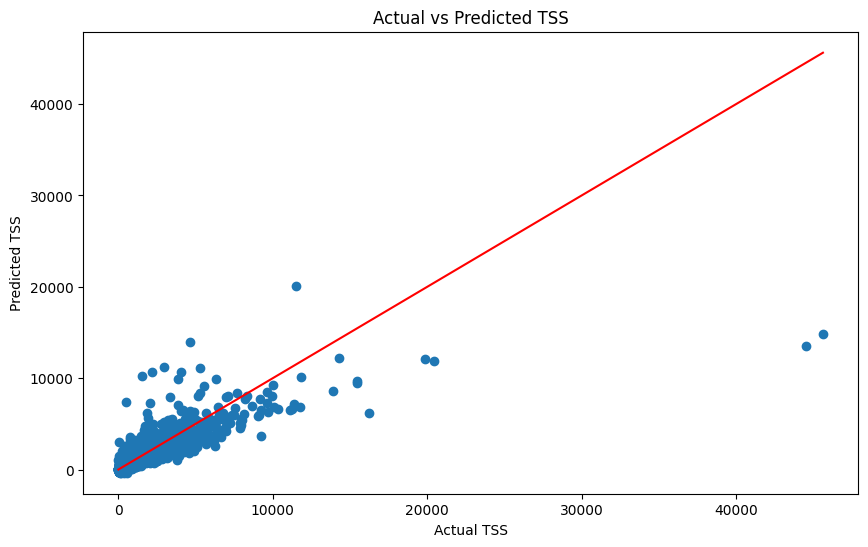

R-squared: 0.6870518045537062


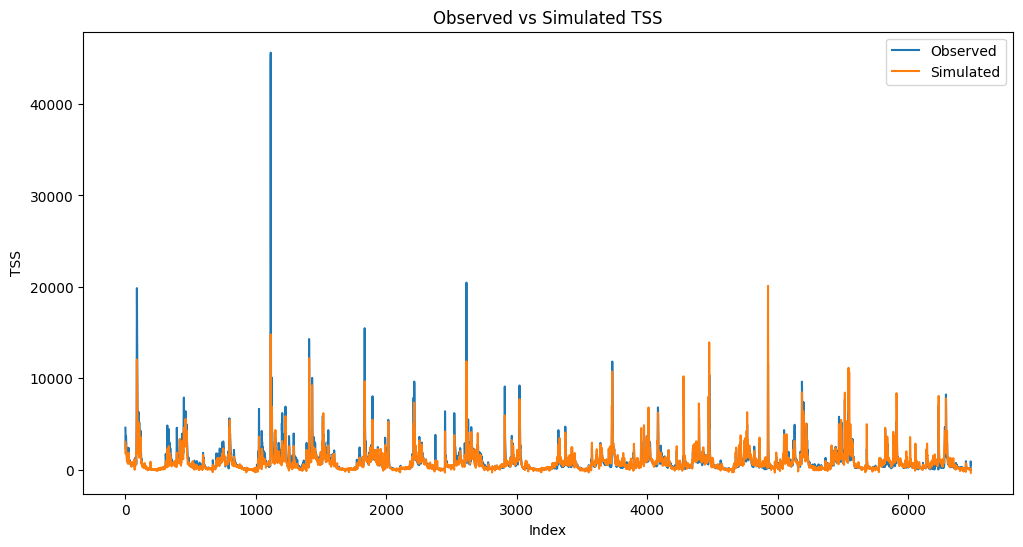

In [2]:

# Load the data
data = pd.read_csv("data/Data NO3.csv")

# View the first few rows of the dataset
print(data.head())

# Define and apply min-max scaling to the features
scaler = MinMaxScaler()
features = [
    "DOY",
    "SWATNO3",
    "Streamflow",
    "Precipitation",
    "MaxT",
    "MinT",
    "Evapotranspiration",
]
data[features] = scaler.fit_transform(data[features])

# Keep the original order by creating an index column
data["OriginalIndex"] = range(len(data))

# Split the data into training and testing sets
X = data[features]
y = data["NO3"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# Define the neural network model
model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(len(features),)),
        Dense(32, activation="relu"),
        Dense(1),
    ]
)

# Compile the model
model.compile(loss="mse", optimizer=Adam(), metrics=["mae"])

# Train the model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1
)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

# Make predictions on both training and testing data
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Combine the original indices, predictions, and actual values into one DataFrame
train_results = pd.DataFrame(
    {
        "OriginalIndex": X_train.index,
        "Observations": y_train,
        "Predicted": train_predictions.flatten(),
        "Period": "Training",
    }
)

test_results = pd.DataFrame(
    {
        "OriginalIndex": X_test.index,
        "Observations": y_test,
        "Predicted": test_predictions.flatten(),
        "Period": "Testing",
    }
)

combined_results = pd.concat([train_results, test_results])
combined_results = combined_results.sort_values("OriginalIndex").reset_index(drop=True)

# Export the combined data frame to a CSV file
combined_results.to_csv("model_predictions_tss_chronological.csv", index=False)

# Plot actual vs predicted streamflow
plt.figure(figsize=(10, 6))
plt.scatter(combined_results["Observations"], combined_results["Predicted"])
plt.plot(
    [min(combined_results["Observations"]), max(combined_results["Observations"])],
    [min(combined_results["Observations"]), max(combined_results["Observations"])],
    color="red",
)
plt.xlabel("Actual TSS")
plt.ylabel("Predicted TSS")
plt.title("Actual vs Predicted TSS")
plt.show()

# Calculate R-squared
residuals = combined_results["Observations"] - combined_results["Predicted"]
ss_res = np.sum(residuals**2)
ss_tot = np.sum(
    (combined_results["Observations"] - np.mean(combined_results["Observations"])) ** 2
)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared}")

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(
    combined_results["OriginalIndex"],
    combined_results["Observations"],
    label="Observed",
)
plt.plot(
    combined_results["OriginalIndex"], combined_results["Predicted"], label="Simulated"
)
plt.xlabel("Index")
plt.ylabel("TSS")
plt.title("Observed vs Simulated TSS")
plt.legend()
plt.show()

# Assess the importance of each explanatory variable using SHAP
# explainer = KernelExplainer(model.predict, X_train)
# shap_values = explainer.shap_values(X_test)
# summary_plot(shap_values, X_test, plot_type="bar")


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the mean squared error
mse = mean_squared_error(y_test, test_predictions)
print(f"Mean Squared Error: {mse}")

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, test_predictions)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 1065522.1853643097
Mean Absolute Error: 318.26930458099474


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import median_absolute_error, r2_score


In [26]:
import numpy as np


def nse_score(observed, simulated):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) between observed and simulated data.

    Parameters:
    observed (array-like): Array of observed values.
    simulated (array-like): Array of simulated/predicted values.

    Returns:
    float: NSE value.
    """
    observed = np.asarray(observed)
    simulated = np.asarray(simulated)

    if observed.shape != simulated.shape:
        raise ValueError("Observed and simulated arrays must have the same shape.")

    numerator = np.sum((simulated - observed) ** 2)
    denominator = np.var(observed, ddof=1) * len(observed)

    nse = 1 - numerator / denominator
    return nse


def pbias_score(simulated, observed):
    """
    Calculate Percent Bias (PBIAS)
    PBIAS = [Σ(Qo - Qs) * 100] / Σ(Qo)
    where:
    Qo = observed discharge
    Qs = simulated discharge
    """
    numerator = (np.sum(observed) - np.sum(simulated)) * 100
    denominator = np.sum(observed)
    return numerator / denominator


In [179]:

sediments = pd.read_excel("data/SWAT_VSA_Ensemble_Calibration.xlsx", sheet_name="Sediments", usecols="A:C")
sediments = sediments[sediments['Date'] < '2007-01-01']
nitrate = pd.read_excel("data/SWAT_VSA_Ensemble_Calibration.xlsx", sheet_name="Nitrate", usecols="A:C")
phosphate = pd.read_excel("data/SWAT_VSA_Ensemble_Calibration.xlsx", sheet_name="Phosphate", usecols="A:C")
sediments

,Date,observed,simulated
0,1993-01-01,727.587922,1019.00
1,1993-02-01,23.161933,10.81
2,1993-03-01,12716.462017,2930.00
3,1993-04-01,7869.031317,4720.00
4,1993-05-01,94.675734,724.50
...,...,...,...
163,2006-08-01,1555.620034,1822.00
164,2006-09-01,536.341238,1311.00
165,2006-10-01,8247.448720,1731.00
166,2006-11-01,9332.619713,2056.00


In [180]:
from scipy.stats import pearsonr


def r_squared(observed, simulated):
    correlation, _ = pearsonr(observed, simulated)
    return correlation**2


In [181]:
r2 = r2_score(sediments["observed"], sediments["simulated"])
r22 = r_squared(sediments["observed"], sediments["simulated"])
nse_2 = nse_score(sediments["observed"], sediments["simulated"])
pbias = pbias_score(sediments["simulated"], sediments["observed"])

print("Sediments: ")
print(f"R²: {r2}")
print(f"R²2: {r22}")
print(f"nse_score: {nse_2}")
print(f"PBIAS: {pbias}")
print("---")

r2_nitrate = r2_score(nitrate["Observed"], nitrate["Simulated"])
r22_nitrate = r_squared(nitrate["Observed"], nitrate["Simulated"])
nse_2_nitrate = nse_score(nitrate["Observed"], nitrate["Simulated"])
pbias_nitrate = pbias_score(nitrate["Simulated"], nitrate["Observed"])

print("Nitrate: ")
print(f"R²: {r2_nitrate}")
print(f"R²2: {r22_nitrate}")
print(f"nse_score: {nse_2_nitrate}")
print(f"PBIAS: {pbias_nitrate}")
print("---")

r2_phosphate = r2_score(phosphate["observed"], phosphate["simulated"])
r22_phosphate = r_squared(phosphate["observed"], phosphate["simulated"])
nse_2_phosphate = nse_score(phosphate["observed"], phosphate["simulated"])
pbias_phosphate = pbias_score(phosphate["simulated"], phosphate["observed"])

print("Phosphate: ")
print(f"R²: {r2_phosphate}")
print(f"R²2: {r22_phosphate}")
print(f"nse_score: {nse_2_phosphate}")
print(f"PBIAS: {pbias_phosphate}")
print("---")

Sediments: 
R²: 0.4615510812734416
R²2: 0.5155489847728576
nse_score: 0.46475613436109964
PBIAS: 8.289363941890995
---
Nitrate: 
R²: 0.5638636693736798
R²2: 0.5893679021474729
nse_score: 0.5659112577803762
PBIAS: 14.667320923422722
---
Phosphate: 
R²: 0.5051843309314517
R²2: 0.5123158949594182
nse_score: 0.5075074091899895
PBIAS: -10.25257882925882
---


In [13]:
r2 = r2_score(sediments["observed"], sediments["simulated"])
nse = nse_score(sediments["observed"], sediments["simulated"])
pbias = pbias_score(sediments["observed"], sediments["simulated"])

print("Sediments: ")
print(f"R²: {r2}")
print(f"NSE: {nse}")
print(f"PBIAS: {pbias}")
print("---")

r2_nitrate = r2_score(nitrate["Observed"], nitrate["Simulated"])
nse_nitrate = nse_score(nitrate["Observed"], nitrate["Simulated"])
pbias_nitrate = pbias_score(nitrate["Observed"], nitrate["Simulated"])

print("Nitrate: ")
print(f"R²: {r2_nitrate}")
print(f"NSE: {nse_nitrate}")
print(f"PBIAS: {pbias_nitrate}")
print("---")

r2_phosphate = r2_score(phosphate["observed"], phosphate["simulated"])
nse_phosphate = nse_score(phosphate["observed"], phosphate["simulated"])
pbias_phosphate = pbias_score(phosphate["observed"], phosphate["simulated"])

print("Phosphate: ")
print(f"R²: {r2_phosphate}")
print(f"NSE: {nse_phosphate}")
print(f"PBIAS: {pbias_phosphate}")
print("---")


Sediments: 
R²: 0.29417366767186337
NSE: -5.56078154549711
PBIAS: -30.95029676527204
---
Nitrate: 
R²: 0.5638636693736798
NSE: 0.3457081509436313
PBIAS: -17.188398491813803
---
Phosphate: 
R²: 0.5051843309314517
NSE: 0.03443637879119299
PBIAS: 9.299173713783457
---
